### Criteria to choose data for regression: relative profiles consideration

From previous notebook, we have apply several criterion based on regression results of individual profiles. Here we would like to apply criteria based on relation between profiles. One obvious parameter is to look at is dail energy production. If daily energy production is relatively low compared to neighbor days. We can reject those daily profiles out.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
%matplotlib inline

In [13]:
#specify data source 
datasource = 'L'
#datasource = 'Stanford'

In [14]:
#zipcode = '08640'
#zipcode = '08641' # do have data only here
zipcode = '92562' 
#zipcode = '92563' 
#[datasource, zipcode] = ['Stanford','94305']

In [15]:
training_data_choice = 0 #0 is full, 1 is first half, 2 is second half (For validation purpose. Check 01_07 for more detail)

In [16]:
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
#we can choose which data to look at.
dataDir = mainDir + '/data/solar/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'

In [17]:
if training_data_choice == 0:
    dsummary = pd.read_csv(outputDir+'/fitsummary.csv')
if training_data_choice == 1:
    dsummary = pd.read_csv(outputDir+'/fitsummary_1.csv')
if training_data_choice == 2:
    dsummary = pd.read_csv(outputDir+'/fitsummary_2.csv')


In [18]:
dsummary.Date = dsummary.Date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").date())

Let's look at data with individual profile selection so far.

"\nfor tl in ax1.get_yticklabels():\n    tl.set_color('b')\n    \nax2 = ax1.twinx()\nax2.plot(dsummary.DBW[dsummary.FirstCheck & dsummary.PeakCheck], dsummary.Rsq[dsummary.FirstCheck & dsummary.PeakCheck], 'r.')\nax2.set_ylabel('Rsq', color='r')\nax2.set_ylim(0,1)\nfor tl in ax2.get_yticklabels():\n    tl.set_color('r')\n    \nfor i in [-90,-180,-270]:\n    plt.axvline(x=i, color='black')\nfor i in [-45,-45-90,-45-180,-45-270]:\n    plt.axvline(x=i, color='black',linestyle='--')\nplt.xlim(-365,0)\n"

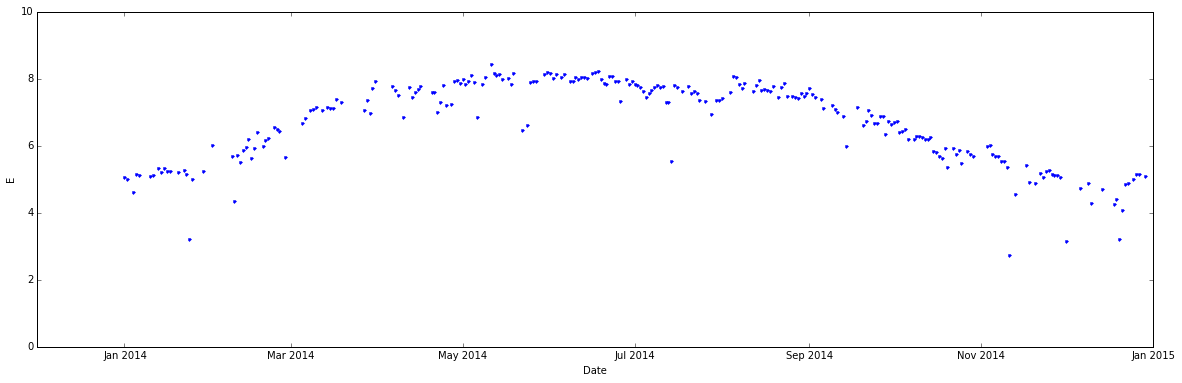

In [23]:
#For Thesis
fig = plt.figure(figsize=(20,6))
ax1  = fig.add_subplot(111)

ax1.plot(dsummary.Date[dsummary.FirstCheck & dsummary.PeakCheck], dsummary.E[dsummary.FirstCheck & dsummary.PeakCheck], 'b.')
ax1.set_xlim([datetime.datetime.strptime("2013-12-01" +" 00:00:00","%Y-%m-%d %H:%M:%S").date(),\
              datetime.datetime.strptime("2015-01-01" +" 00:00:00","%Y-%m-%d %H:%M:%S").date()])
#ax1.set_xlabel('day before winter solstice')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('E')#, color='b')
ax1.set_ylim([0,10])
ax1.set_xlabel('Date')
'''
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(dsummary.DBW[dsummary.FirstCheck & dsummary.PeakCheck], dsummary.Rsq[dsummary.FirstCheck & dsummary.PeakCheck], 'r.')
ax2.set_ylabel('Rsq', color='r')
ax2.set_ylim(0,1)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
for i in [-90,-180,-270]:
    plt.axvline(x=i, color='black')
for i in [-45,-45-90,-45-180,-45-270]:
    plt.axvline(x=i, color='black',linestyle='--')
plt.xlim(-365,0)
'''

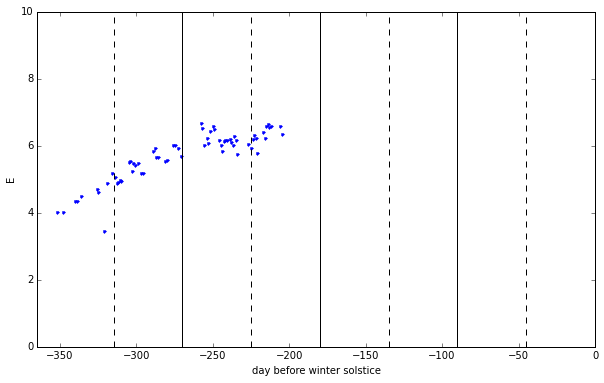

In [31]:
#For Thesis
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

ax1.plot(dsummary.DBW[dsummary.FirstCheck & dsummary.PeakCheck], dsummary.E[dsummary.FirstCheck & dsummary.PeakCheck], 'b.')
#ax1.set_xlim([datetime.datetime.strptime("2013-01-01" +" 00:00:00","%Y-%m-%d %H:%M:%S").date(),\
#              datetime.datetime.strptime("2015-01-01" +" 00:00:00","%Y-%m-%d %H:%M:%S").date()])
ax1.set_xlabel('day before winter solstice')
plt.xlim([-365,0])
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('E')#, color='b')
ax1.set_ylim([0,10])
  
for i in [-90,-180,-270]:
    plt.axvline(x=i, color='black')
for i in [-45,-45-90,-45-180,-45-270]:
    plt.axvline(x=i, color='black',linestyle='--')

(-365, 0)

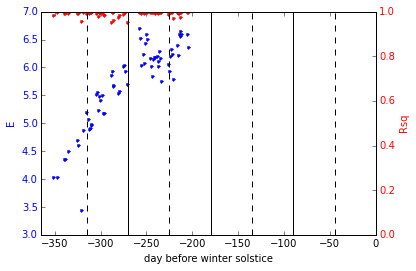

In [32]:
fig, ax1 = plt.subplots()
ax1.plot(dsummary.DBW[dsummary.FirstCheck & dsummary.PeakCheck], dsummary.E[dsummary.FirstCheck & dsummary.PeakCheck], 'b.')
ax1.set_xlabel('day before winter solstice')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('E', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(dsummary.DBW[dsummary.FirstCheck & dsummary.PeakCheck], dsummary.Rsq[dsummary.FirstCheck & dsummary.PeakCheck], 'r.')
ax2.set_ylabel('Rsq', color='r')
ax2.set_ylim(0,1)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
for i in [-90,-180,-270]:
    plt.axvline(x=i, color='black')
for i in [-45,-45-90,-45-180,-45-270]:
    plt.axvline(x=i, color='black',linestyle='--')
plt.xlim(-365,0)

Here we introduce a concept of valley. A data point is in a valley if both sides of a data point have higher points. If we assume that the lowest point is at winter solstice, then there should be no point in a valley. So we select points not in valleys. If the lowest point is not at winter solstice, we start losing good data points by such selection. For now, let's assume that such loss is tolerable. We allow 10% flexibility as well.

Note: we run relative profiles consideration on multi-year data.

In [33]:
#this is 10% flexibility, not good if the ideal minimum is not at winter solstice

'''
dsummary_pickup = dsummary[dsummary.FirstCheck & dsummary.PeakCheck]
#dsummary_pickup = dsummary[dsummary.ThirdCheck]
#dsummary_pickup = dsummary
dsummary_pickup['IsValley'] = False
for i in range(0,dsummary_pickup.shape[0]):
    d = dsummary_pickup.DBW.iloc[i] 
    e = dsummary_pickup.E.iloc[i]
    #data teasing near winter solstice. Enforce them to be valley automatically
    if (d>-3.5)| (d<-365+3.5):
        dsummary_pickup.IsValley.iloc[i] = True
    elif np.max(dsummary_pickup.E[dsummary_pickup.DBW==d]) > 1.1*e:
        dsummary_pickup.IsValley.iloc[i] = True
    else:
        if (np.sum(dsummary_pickup.DBW<d) > 0) & (np.sum(dsummary_pickup.DBW>d) > 0):
            dsummary_pickup.IsValley.iloc[i] = (1.1*e<np.max(dsummary_pickup.E[dsummary_pickup.DBW<d]))&\
                            (1.1*e<np.max(dsummary_pickup.E[dsummary_pickup.DBW>d]))
'''
[0]

[0]

In [34]:
#This is new argument to detect the steepness of decline

dsummary_pickup = dsummary[dsummary.FirstCheck & dsummary.PeakCheck]

data_table = dsummary_pickup
column_name = 'E'
threshold = 0.05

data_table['ValleyCheck'] = False
for i in range(0,data_table.shape[0]):
    d = data_table.DBW.iloc[i] 
    e = data_table[column_name].iloc[i]
    #allowed to add "same" points if there are good with 5% flexibility
    if e < 0.95*np.max(data_table[column_name][data_table.DBW==d]):
        data_table.ValleyCheck.iloc[i] = True
    else:
        if (np.sum(data_table.DBW<d) > 0)\
            & (e<np.max(data_table[column_name][data_table.DBW<d])):

            left_steep = -(data_table[column_name][(data_table.DBW<d)&(data_table[column_name]>e)]-e)/\
                (data_table.DBW[(data_table.DBW<d)&(data_table[column_name]>e)]-d)

            if (np.max(left_steep)>threshold):
                data_table.ValleyCheck.iloc[i] = True

        if (np.sum(data_table.DBW>d) > 0)\
            & (e<np.max(data_table[column_name][data_table.DBW>d])):

            right_steep = (data_table[column_name][(data_table.DBW>d)&(data_table[column_name]>e)]-e)/\
                (data_table.DBW[(data_table.DBW>d)&(data_table[column_name]>e)]-d)

            if (np.max(right_steep)>threshold):
                data_table.ValleyCheck.iloc[i] = True

dsummary_pickup['IsValley'] = data_table.ValleyCheck
               

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:31

In [35]:
dsummary['SecondCheck']=False
dsummary.SecondCheck[dsummary_pickup.index]=dsummary_pickup.IsValley.map(lambda x: not x)

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


(-365, 0)

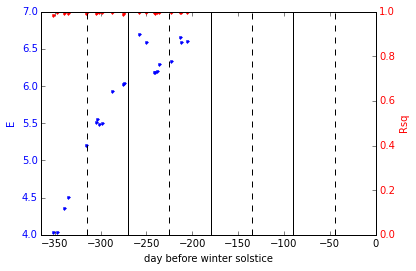

In [36]:
fig, ax1 = plt.subplots()
ax1.plot(dsummary.DBW[dsummary.SecondCheck], dsummary.E[dsummary.SecondCheck], 'b.')
ax1.set_xlabel('day before winter solstice')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('E', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(dsummary.DBW[dsummary.SecondCheck], dsummary.Rsq[dsummary.SecondCheck], 'r.')
ax2.set_ylabel('Rsq', color='r')
ax2.set_ylim(0,1)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
for i in [-90,-180,-270]:
    plt.axvline(x=i, color='black')
for i in [-45,-45-90,-45-180,-45-270]:
    plt.axvline(x=i, color='black',linestyle='--')
plt.xlim(-365,0)
#plt.savefig(directory+'/04filter.png')
#plt.show()

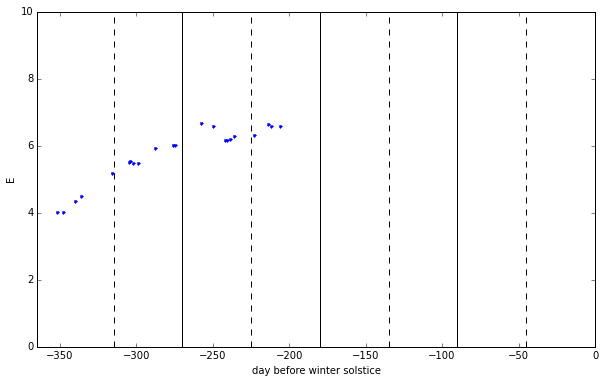

In [37]:
#For Thesis
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

ax1.plot(dsummary.DBW[dsummary.SecondCheck], dsummary.E[dsummary.SecondCheck], 'b.')
#ax1.set_xlim([datetime.datetime.strptime("2013-01-01" +" 00:00:00","%Y-%m-%d %H:%M:%S").date(),\
#              datetime.datetime.strptime("2015-01-01" +" 00:00:00","%Y-%m-%d %H:%M:%S").date()])
ax1.set_xlabel('day before winter solstice')
plt.xlim([-365,0])
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('E')#, color='b')
ax1.set_ylim([0,10])
#ax1.set_xlabel('Date')

for i in [-90,-180,-270]:
    plt.axvline(x=i, color='black')
for i in [-45,-45-90,-45-180,-45-270]:
    plt.axvline(x=i, color='black',linestyle='--')

In [38]:
#For thesis
np.sum(dsummary.SecondCheck)*1.0/dsummary.shape[0]

0.024971623155505107

Note that the criterion is quite strict since it does not allow any deviation. In multiyear consideration, we use factor 1.1 instead of 1 to allow slight dips.

#### Daily Energy and coefficients fitting: quantile regression (more preferable than iterative fitting)

Next we would like to fit quantile regression with splines over daily energy production to explain variation over a year. A natural set of knots are 4 points in year. In addition, we know that we want function to be periodic. However, it does not work well due to the shape of function.

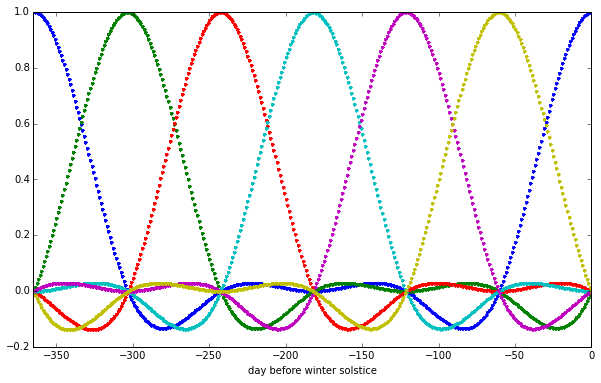

In [39]:
num_knots = 6
x = dsummary.DBW
y = patsy.dmatrix("cc(x, df="+str(num_knots)+", upper_bound = 0, lower_bound = -365)-1", {"x": x})

#For Thesis
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

X = y
b = np.array([1]*X.shape[1])
ax1.plot(x,X*b,'.')
ax1.set_xlim(-365,0)
ax1.set_xlabel('day before winter solstice')

In [40]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg

In [41]:
dsummary_pickup = dsummary[dsummary.SecondCheck]

Note: since we have only half year data for 94305, we need to play to trick by making a copy and flip a date.

In [42]:

if zipcode=='94305':
    #dsummary_pickupcopy = dsummary_pickup
    original_size = dsummary_pickup.shape[0]
    dsummary_pickup =dsummary_pickup.append(dsummary_pickup)
    dsummary_pickup.reset_index(inplace=True)
    dsummary_pickup['DBW'].iloc[range(original_size,2*original_size)] = \
                -360-dsummary_pickup['DBW'].iloc[range(original_size,2*original_size)]
    
    #dsummary_pickup =dsummary_pickup.append(dsummary_pickupcopy)

In [43]:
xpredict = np.sort(dsummary.DBW)

C:\Users\Admin\Anaconda\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
C:\Users\Admin\Anaconda\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)


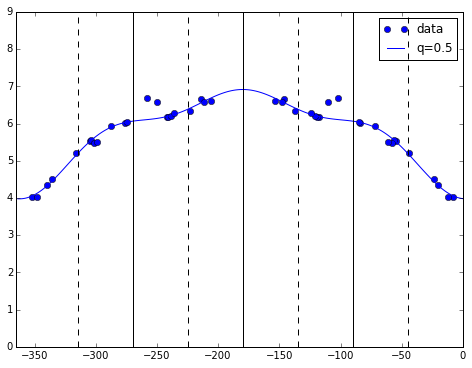

In [44]:

#x = np.sort(dsummary_pickup.DBW)
x = dsummary_pickup.DBW

#Fouriers does not work
num_waves = 3
X = np.ones((len(x), 2*num_waves+1))
for i in range(0,num_waves):
    X[:,(2*i)] = x.map(lambda x: np.sin((i+1)*x*1.0/365*2*np.pi))
    X[:,(2*i+1)] = x.map(lambda x: np.cos((i+1)*x*1.0/365*2*np.pi))
    
#X = sm.add_constant(X)
y = dsummary_pickup.E
#resrlm2 = sm.RLM(y, X).fit()
#resrlm1 = sm.QuantReg(y, X).fit(q=0.5)
#resrlm2 = sm.QuantReg(y, X).fit(q=0.9)
resrlm3 = sm.QuantReg(y, X).fit(q=0.5)

X = np.ones((len(xpredict), 2*num_waves+1))
for i in range(0,num_waves):
    X[:,(2*i)] = map(lambda x: np.sin((i+1)*x*1.0/365*2*np.pi), xpredict)
    X[:,(2*i+1)] = map(lambda x: np.cos((i+1)*x*1.0/365*2*np.pi),xpredict)

ypredict3 = resrlm3.predict(X)
    
    
#plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, 'o', label="data")

#Splines

'''
y = patsy.dmatrix("cc(x, df="+str(num_knots)+", upper_bound = 0, lower_bound = -365)-1", {"x": xshift})
X = y

#X = sm.add_constant(X)
y = dsummary_pickup.E
#resrlm2 = sm.RLM(y, X).fit()
#resrlm1 = sm.QuantReg(y, X).fit(q=0.5)
#resrlm2 = sm.QuantReg(y, X).fit(q=0.9)
resrlm3 = sm.QuantReg(y, X).fit(q=0.95)

ypredict1 = resrlm1.predict(patsy.dmatrix("cc(x, df="+str(num_knots)+", upper_bound = 0, lower_bound = -365)-1", {"x": xpredict}))
#ypredict2 = resrlm2.predict(patsy.dmatrix("cc(x, df="+str(num_knots)+", upper_bound = 0, lower_bound = -365)-1", {"x": xpredict}))
#ypredict3 = resrlm3.predict(patsy.dmatrix("cc(x, df="+str(num_knots)+", upper_bound = 0, lower_bound = -365)-1", {"x": xpredict}))
'''

#ax.plot(xpredict, ypredict1, 'r-', label="q=0.5")
#ax.plot(xpredict, ypredict2, 'g-', label="q=0.9")
ax.plot(xpredict, ypredict3, 'b-', label="q=0.5")
legend = ax.legend(loc="best")

for i in [-90,-180,-270]:
    plt.axvline(x=i, color='black')
for i in [-45,-45-90,-45-180,-45-270]:
    plt.axvline(x=i, color='black',linestyle='--')
plt.xlim(-365,0)
plt.ylim(0,9)
plt.show()

However, it seems working fine on coefficients.

In [45]:
#Build function to to detect the steepness of decline

def valleyscreen(data_table, column_name, threshold):

    data_table['ValleyCheck'] = False
    for i in range(0,data_table.shape[0]):
        d = data_table.DBW.iloc[i] 
        e = data_table[column_name].iloc[i]
        #allowed to add "same" points if there are good with 5% flexibility
        if e < 0.95*np.max(data_table[column_name][data_table.DBW==d]):
            data_table.ValleyCheck.iloc[i] = True
        else:
            #ensure they are surroundded and in the valley
            '''
            if (np.sum(data_table.DBW<d) > 0) & (np.sum(data_table.DBW>d) > 0)\
                & (e<np.max(data_table[column_name][data_table.DBW<d])) & (e<np.max(data_table[column_name][data_table.DBW>d])):

                left_steep = -(data_table[column_name][(data_table.DBW<d)&(data_table[column_name]>e)]-e)/\
                    (data_table.DBW[(data_table.DBW<d)&(data_table[column_name]>e)]-d)

                right_steep = (data_table[column_name][(data_table.DBW>d)&(data_table[column_name]>e)]-e)/\
                    (data_table.DBW[(data_table.DBW>d)&(data_table[column_name]>e)]-d)

                if (np.max(right_steep)>threshold) | (np.max(left_steep)>threshold):
                    data_table.ValleyCheck.iloc[i] = True
                    '''
                    
            if (np.sum(data_table.DBW<d) > 0)\
                & (e<np.max(data_table[column_name][data_table.DBW<d])):

                left_steep = -(data_table[column_name][(data_table.DBW<d)&(data_table[column_name]>e)]-e)/\
                    (data_table.DBW[(data_table.DBW<d)&(data_table[column_name]>e)]-d)

                if (np.max(left_steep)>threshold):
                    data_table.ValleyCheck.iloc[i] = True
            
            if (np.sum(data_table.DBW>d) > 0)\
                & (e<np.max(data_table[column_name][data_table.DBW>d])):

                right_steep = (data_table[column_name][(data_table.DBW>d)&(data_table[column_name]>e)]-e)/\
                    (data_table.DBW[(data_table.DBW>d)&(data_table[column_name]>e)]-d)

                if (np.max(right_steep)>threshold):
                    data_table.ValleyCheck.iloc[i] = True

    return data_table[data_table.ValleyCheck==False]

In [59]:
d = dsummary_pickup#dsummary[dsummary.SecondCheck]
qcontrol = 0.5#0.5 #0.95
model_list = [0]*11
ax_list = [0]*11

if zipcode == '94305':
    t = 0.02
else:
    t = 0.005

for i in range(0,11):
    column_name = 'c'+str(i)
    imm = valleyscreen(dsummary_pickup,column_name,t)
    x = imm.DBW
    #num_waves = 3
    X = np.ones((len(x), 2*num_waves+1))
    for j in range(0,num_waves):
        X[:,(2*j)] = x.map(lambda x: np.sin((j+1)*x*1.0/365*2*np.pi))
        X[:,(2*j+1)] = x.map(lambda x: np.cos((j+1)*x*1.0/365*2*np.pi))
    #y = patsy.dmatrix("cc(x, df="+str(num_knots)+", upper_bound = 0, lower_bound = -365)-1", {"x": x})
    #X = y
    y = imm[column_name]
    model_list[i] = sm.QuantReg(y, X).fit(q=qcontrol)

C:\Users\Admin\Anaconda\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)


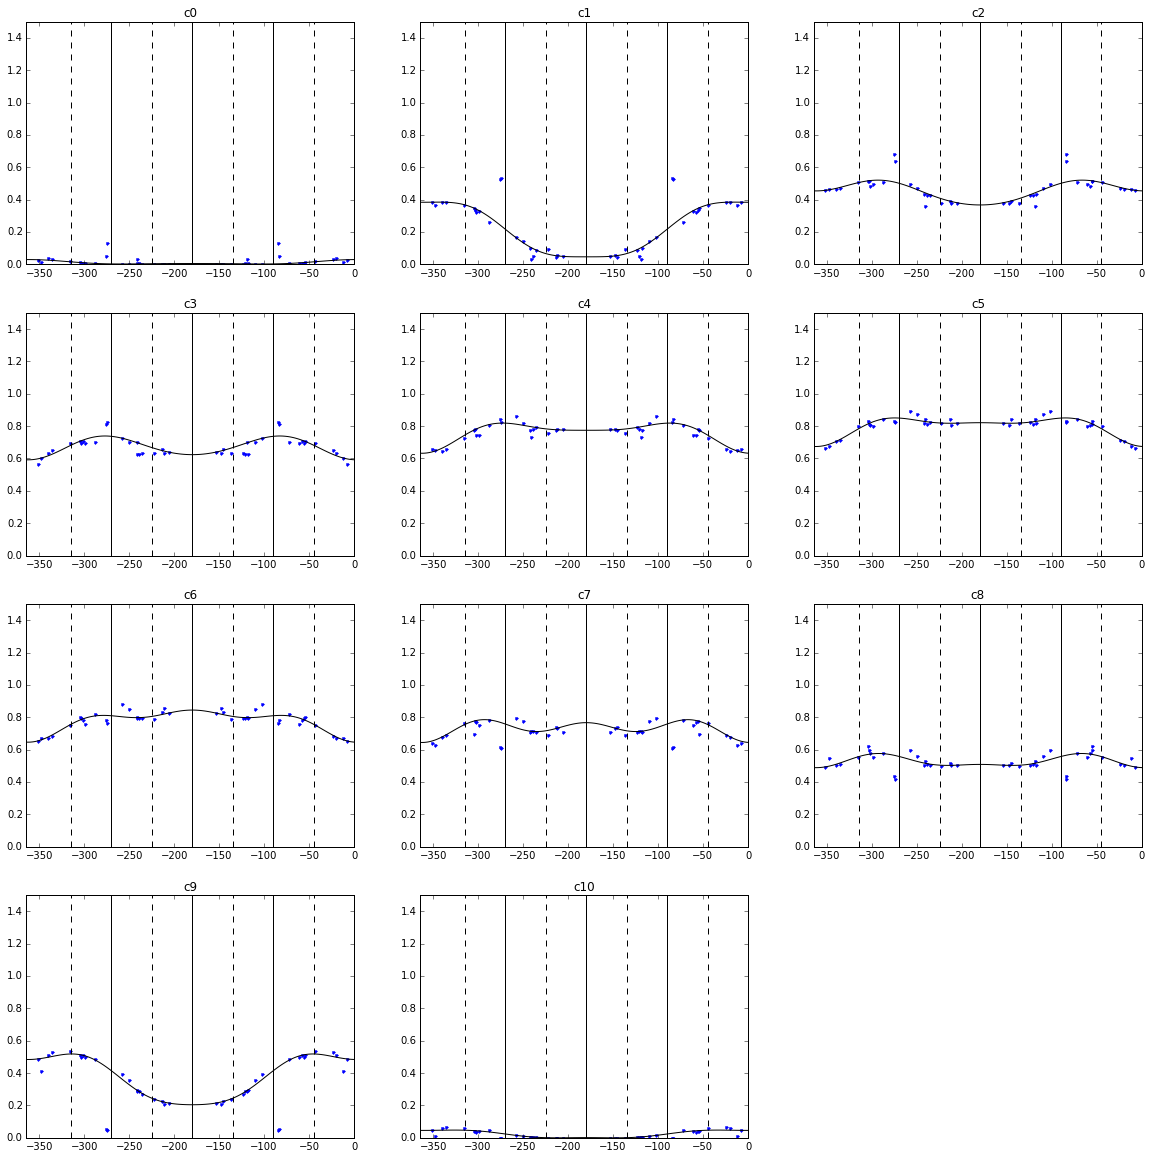

In [60]:
fig = plt.figure(figsize=(20,20))

for num in range(0,11):

    column_name = 'c'+str(num)
    
    X = np.ones((len(xpredict), 2*num_waves+1))
    for i in range(0,num_waves):
        X[:,(2*i)] = map(lambda x: np.sin((i+1)*x*1.0/365*2*np.pi), xpredict)
        X[:,(2*i+1)] = map(lambda x: np.cos((i+1)*x*1.0/365*2*np.pi),xpredict)

    ypredict = model_list[num].predict(X)

    #ypredict = model_list[num].predict(patsy.dmatrix("cc(x, df="+str(num_knots)+",upper_bound = 0, lower_bound = -365)-1", {"x": xpredict}))

    ax_list[num]  = fig.add_subplot(4,3,num+1) 
    ax_list[num].plot(d.DBW, d[column_name],marker='.', ls='None')
    #imm = valleyscreen(dsummary_pickup,column_name,0.005)
    #ax_list[num].plot(imm.DBW, imm[column_name],marker='.', ls='None')
    
    ax_list[num].plot(xpredict, ypredict, '-',color='black')
    ax_list[num].set_title(column_name)
    for i in [-90,-180,-270]:
        ax_list[num].axvline(x=i, color='black')
    for i in [-45,-45-90,-45-180,-45-270]:
        ax_list[num].axvline(x=i, color='black',linestyle='--')
    ax_list[num].set_xlim(-365,0)
    ax_list[num].set_ylim(0,1.5)

if training_data_choice == 0:
    plt.savefig(outputDir+'/coeffit.png')
if training_data_choice == 1:
    plt.savefig(outputDir+'/coeffit_1.png')
if training_data_choice == 2:
    plt.savefig(outputDir+'/coeffit_2.png')

plt.show()

we can use predicted coefficients to produce envelopes for all power profiles and daily energy production.

In [61]:
if training_data_choice == 0:
    dsummary.to_csv(outputDir+"/fitsummary.csv",index=False)
if training_data_choice == 1:
    dsummary.to_csv(outputDir+"/fitsummary_1.csv",index=False)
if training_data_choice == 2:
    dsummary.to_csv(outputDir+"/fitsummary_2.csv",index=False)


We would like to collect coefficients for all possible DateNum as well (just in case training data on certain day is missing).

In [62]:
FullModelCoef = pd.DataFrame(0, index = np.arange(365), columns = ['DBW','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9','c10'])
FullModelCoef['DBW'] = range(0,-365,-1)

In [63]:
x = FullModelCoef.DBW
for i in range(0,11):
    X = np.ones((len(x), 2*num_waves+1))
    for j in range(0,num_waves):
        X[:,(2*j)] = map(lambda x: np.sin((j+1)*x*1.0/365*2*np.pi), x)
        X[:,(2*j+1)] = map(lambda x: np.cos((j+1)*x*1.0/365*2*np.pi),x)
        
    FullModelCoef['c'+str(i)] = model_list[i].predict(X)
        
    #FullModelCoef['c'+str(i)] = model_list[i].predict(patsy.dmatrix("cc(x, df="+str(num_knots)+",upper_bound = 0, lower_bound = -365)-1", {"x": x}))


In [64]:
if training_data_choice == 0:
    FullModelCoef.to_csv(outputDir+"/FullModelCoef.csv",index=False)
if training_data_choice == 1:
    FullModelCoef.to_csv(outputDir+"/FullModelCoef_1.csv",index=False)
if training_data_choice == 2:
    FullModelCoef.to_csv(outputDir+"/FullModelCoef_2.csv",index=False)

#### Another method on Daily Energy and coefficients fitting: iterative fitting (not as good as quantile regression)

Iterative fitting can be used instead of quantile regression. However, the result is not as good.

In [65]:
'''
threshold = max(dsummary.E)*0.05
FourthCheckOld = dsummary.FourthCheck
dsummary_pickup = dsummary[dsummary.FourthCheck]
x = np.sort(dsummary_pickup.DateNum)
y = patsy.dmatrix("cc(x, df=4)-1", {"x": x})
X = y

X = sm.add_constant(X)
y = dsummary_pickup.E
resrlm2 = sm.RLM(y, X).fit()

xpredict = np.sort(dsummary.DateNum)
ypredict = resrlm2.predict(sm.add_constant(patsy.dmatrix("cc(x, df=4)-1", {"x": xpredict})))

#plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, 'o', label="data")
ax.plot(xpredict, ypredict, 'r-', label="RLM")
legend = ax.legend(loc="best")
for i in ImportantDates:
    plt.axvline(x=(i-DecSolstice).days, color='black')
plt.xlim(-365,0)
plt.show()

dsummary_pickup['residual'] = dsummary_pickup.E - resrlm2.fittedvalues
#Here we would like to preserve points in all quarters. Otherwise, points will be vanished
dsummary_pickup_1 = dsummary_pickup[dsummary_pickup.DateNum > -365/4]
dsummary_pickup_2 = dsummary_pickup[(dsummary_pickup.DateNum <= -365/4)&(dsummary_pickup.DateNum > -2*365/4)]
dsummary_pickup_3 = dsummary_pickup[(dsummary_pickup.DateNum <= -2*365/4)&(dsummary_pickup.DateNum > -3*365/4)]
dsummary_pickup_4 = dsummary_pickup[dsummary_pickup.DateNum <= -3*365/4]
if(max(abs(dsummary_pickup_1.residual))>threshold):
    dsummary_pickup_1['FourthCheck'] = dsummary_pickup_1.residual > np.percentile(dsummary_pickup_1.residual,10)
if(max(abs(dsummary_pickup_2.residual))>threshold):
    dsummary_pickup_2['FourthCheck'] = dsummary_pickup_2.residual > np.percentile(dsummary_pickup_2.residual,10)
if(max(abs(dsummary_pickup_3.residual))>threshold):
    dsummary_pickup_3['FourthCheck'] = dsummary_pickup_3.residual > np.percentile(dsummary_pickup_3.residual,10)
if(max(abs(dsummary_pickup_4.residual))>threshold):
    dsummary_pickup_4['FourthCheck'] = dsummary_pickup_4.residual > np.percentile(dsummary_pickup_4.residual,10)
dsummary['FourthCheck']=False
dsummary.FourthCheck[dsummary_pickup_1.index]=dsummary_pickup_1.FourthCheck
dsummary.FourthCheck[dsummary_pickup_2.index]=dsummary_pickup_2.FourthCheck
dsummary.FourthCheck[dsummary_pickup_3.index]=dsummary_pickup_3.FourthCheck
dsummary.FourthCheck[dsummary_pickup_4.index]=dsummary_pickup_4.FourthCheck
print(sum(dsummary.FourthCheck!=FourthCheckOld))
'''
[0]

[0]